In [11]:
import os 
from pathlib import Path
from import_file import import_file

import numpy as np
import statsmodels.api  as sm
from statsmodels.sandbox.regression.gmm import GMM

#jax_aux_file_jitted_25_01_2023 = import_file(os.path.join(Path(os.getcwd()).parent,'jax_aux_file_jitted_25_01_2023.py'))
def corr_np(s,envelope,envelope_params):
    """return overlap area (i.e. correlation) Corr(X_t,X_{t+s}). these are equivalent because the area of the 
    ambit set is normalised to 1. s >0"""

    assert envelope in ['gamma','exponential','ig']
    
    if envelope == 'exponential':
        u = envelope_params[0]
        area = np.exp(- u * s)
        
    elif envelope == 'gamma':
        H,delta = envelope_params
        area = (1+s/delta)**(-H)
        
    elif envelope == 'ig':
        gamma,delta =  envelope_params
        area = np.exp(delta * gamma *(1-np.sqrt(2*s/gamma**2+1)))
    return area

In [49]:
def get_initial_value_for_1_param_trawl_function(tau_ ,values_,envelope,aux_param):
    assert len(values_.shape) < 2
    
    emp_corr_at_lag_1 =  np.array(sm.tsa.stattools.acf(values_,nlags =1))[[1]]
    
    if envelope == 'exponential':
        assert aux_param == None
        return (-1/tau_) * np.log(emp_corr_at_lag_1)  
    
    elif envelope == 'gamma_H':
        assert isinstance(aux_param,tuple) and len(aux_param) == 1
        delta = aux_param[0]
        return - np.log(emp_corr_at_lag_1) / np.log(1+ tau_/delta)

def corr_np_GMM_gamma_H(delta_):
    
    
    def func__(s,envelope,envelope_params):
        
        assert envelope == 'gamma_H'  
        return  (1+s/delta_)**(-envelope_params[0])
    
    return func__
    
    

class GMMGamma2(GMM):
    def momcond(self, params):
        envelope_params = params
        g = []         
        endog = self.endog

        tau = self.tau
        lags_list= self.lags_list
        envelope = self.envelope


        for index in range(len(lags_list)):
            lag_to_use = lags_list[index]
            tau_to_use = tau * lag_to_use
            empirical_acf = (endog[:-lag_to_use] * endog[lag_to_use:] - endog.mean()**2) / endog.var()
            error_to_add  = empirical_acf - corr_np(tau_to_use,envelope,envelope_params) 
            g.append(error_to_add)

        min_length = min([len(i) for i in g])
        #print(1)
        h = np.column_stack([error[:min_length] for error in g])
        #print(2)
        return h

In [110]:
#############CHANGE THE FOLDER NAME ###########
folder_to_acces = 'results_2'
###############################################
parameters___ = import_file(os.path.join(os.getcwd(),'gamma',folder_to_acces,'parameters'))
lags_list             = parameters___.lags_list
levy_seed             = parameters___.levy_seed
tau                   =  float(parameters___.tau)
envelope              = parameters___.envelope    #envelope  is one of  ['exponential','gamma','ig']
n_values              = parameters___.n_values
TRUE_ENVELOPE_PARAMS  = parameters___.TRUE_ENVELOPE_PARAMS


all_values_ = np.load(os.path.join(os.getcwd(),'gamma',folder_to_acces,'values.npy'))


if envelope == 'exponential':
    print('exponential envelope, nothing to do')
        
elif envelope == 'gamma':
    input_ = input('nr params to be fitted, 1 or 2 \n')
    
    if input_ == '1':
        #if we only fit H, use the true value for delta
        envelope = 'gamma_H'
        corr_np = corr_np_GMM_gamma_H(parameters___.TRUE_ENVELOPE_PARAMS[1]) 
        
    elif input_ == '2':
        #if we fit both H and delta
        starting_point = input('starting points for the envelope params is separated by commas ')
        starting_point = np.array(tuple(float(x) for x in starting_point.split(",")))
        
    else:
        raise ValueError

print(envelope)

exponential envelope, nothing to do
exponential


#### if it's a 2 parameter envelope, start from a fixed point; if it's a 1 parameter envelope, start from the estimator using the correlation at lag 1

In [111]:
d = dict()

for n_to_use in n_values[:2]: 
    for lags_to_use in lags_list:

        l = []
        
        for simulation_number in range(len(all_values_)):
            
            values_to_use = all_values_[simulation_number,:n_to_use].copy()
            
            if envelope == 'exponential':
                starting_point = get_initial_value_for_1_param_trawl_function(tau_ = tau ,values_ = values_to_use.copy(),
                                                            envelope = envelope, aux_param = None)
                
                
            elif envelope =='gamma_H' and input_ == '1':
                starting_point = get_initial_value_for_1_param_trawl_function(tau_ = tau ,values_ = values_to_use.copy(),
                                                            envelope = envelope, aux_param = TRUE_ENVELOPE_PARAMS[1:])
                #print(starting_point)
        
            
            z                = np.ones([len(values_to_use), len(lags_to_use)])
            model            = GMMGamma2(values_to_use, z.copy(), z)
            model.tau        = tau
            model.lags_list  = lags_to_use  #this should be the list of lags, i.e. lags_to_use, not lags_list which is a list of lists
            model.trawl_path = values_to_use
            model.envelope   = envelope
    
            res = model.fit(starting_point,  optim_method='bfgs')
            l.append(res)
        d[(lags_to_use,n_to_use)]  = l

Optimization terminated successfully.
         Current function value: 0.005906
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001450
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001450
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001450
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.007856
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001190
         Iterations: 4
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000382
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000382
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004966
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001566
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001566
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001566
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010263
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001109
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001109
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000371
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000371
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000371
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004296
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000481
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000481
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002477
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002477
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004379
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000492
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000492
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000492
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.019163
         Iterations: 4
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.019176
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.019176
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.019176
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000507
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000121
         Iterations: 1
         Function evaluations: 3
         Gradient

Optimization terminated successfully.
         Current function value: 0.000930
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000930
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001722
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000684
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000684
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000684
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000781
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000781
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000781
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.038251
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.003455
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.003466
         Iterations: 2
         Function evaluations: 4
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000902
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000902
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004483
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001080
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001080
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001080
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000137
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001211
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001211
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001368
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000435
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000435
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000435
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000113
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.014442
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.002726
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002732
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002732
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004711
         Iterations: 3
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002067
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002067
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000782
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001440
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000526
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000526
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000227
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000227
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.017406
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004388
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.004386
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.004386
         Iterations: 0
         Function evaluations: 1
         Gradient e

         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000170
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000170
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000170
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000653
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000157
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000157
         

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000827
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000827
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000116
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000264
         Iterations: 2
         Function evaluations: 4
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000153
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006034
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.002172
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002172
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001152
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001153
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001153
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006643
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001048
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001049
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000269
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000181
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000181
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000181
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.012719
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.005502
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000711
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000711
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000711
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.029164
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.004000
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003999
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.008229
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.008229
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003593
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000918
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000918
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000918
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.006429
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001065
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001065
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001065
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.050346
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.016933
         Iterations: 4
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000656
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000656
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004210
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000937
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001952
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000944
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000944
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000944
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.009262
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002988
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.002990
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002990
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006130
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002807
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002807
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000596
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000596
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004460
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000274
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000274
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000274
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001938
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001938
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001938
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.018496
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003096
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003097
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000793
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000793
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002267
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000311
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000311
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000311
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.009012
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.009021
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.009021
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.020252
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.006024
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.006020
         Iterations: 1
         Function evaluations: 3
         Gradient

Optimization terminated successfully.
         Current function value: 0.000177
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005714
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000483
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000483
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000483
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002625
         Iterations: 6
         Function evaluations: 11
         Gradient 

Optimization terminated successfully.
         Current function value: 0.000839
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001285
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006597
         Iterations: 5
         Function evaluations: 9
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000437
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000437
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004001
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000315
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000315
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000315
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 4
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000639
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000639
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002287
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000204
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000204
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000204
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000491
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000573
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 4
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000320
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000107
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 3
         Function evaluations: 4
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000164
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 0
         Function evaluations: 1
         Gradient e

In [116]:
weighted_gmm = [i.params for i in d[((1, 3, 5,10),  1000)]]


In [117]:
#get_initial_value_for_1_param_trawl_function(tau ,all_values_[0],envelope,TRUE_ENVELOPE_PARAMS[1:])
get_initial_value_for_1_param_trawl_function(tau ,all_values_[15],envelope,None)


array([0.10313228])

In [118]:
import pickle
import matplotlib.pyplot as plt

with open(os.path.join('gamma',folder_to_acces,"gmm_dictionary.pickle"), "rb") as input_file:
     d_gmm   = pickle.load(input_file)
non_weighted_gmm = d_gmm[((1, 3, 5,10),  1000)]['envelope_params']

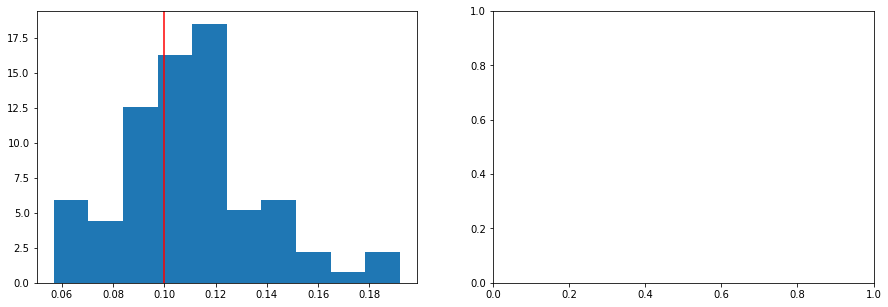

In [119]:
f,ax = plt.subplots(1,2,figsize = (15,5))
_= ax[0].hist(np.array(weighted_gmm)[:,0],density=True)#,range= (0.025,0.4)
ax[0].axvline(TRUE_ENVELOPE_PARAMS[0],c='red')
#_=ax[1].hist(np.array(weighted_gmm)[:,1],density=True) #range=(0,5),
#ax[1].axvline(TRUE_ENVELOPE_PARAMS[1],c='red')

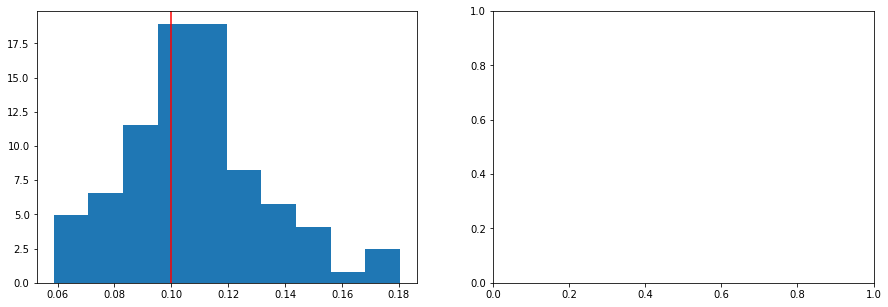

In [120]:
f,ax = plt.subplots(1,2,figsize = (15,5))
_=ax[0].hist(np.array(non_weighted_gmm)[:,0],density = True) #,range= (0.025,0.2)
ax[0].axvline(TRUE_ENVELOPE_PARAMS[0],c='red')
#_=ax[1].hist(np.array(non_weighted_gmm)[:,1],density=True)
#ax[1].axvline(TRUE_ENVELOPE_PARAMS[1],c='red')

values_to_use

In [121]:
np.mean(np.abs(np.array(non_weighted_gmm)- TRUE_ENVELOPE_PARAMS),axis=0)

array([0.01986979])

In [122]:
np.mean(np.abs(np.array(weighted_gmm)- TRUE_ENVELOPE_PARAMS),axis=0)

array([0.02230907])

In [123]:
((np.median(np.abs(np.array(weighted_gmm)- np.array(TRUE_ENVELOPE_PARAMS)),axis=0) / np.median(np.abs(np.array(non_weighted_gmm)- np.array(TRUE_ENVELOPE_PARAMS)),axis=0)))

array([1.12439733])

In [71]:
TRUE_ENVELOPE_PARAMS

(0.2,)

In [170]:
TRUE_ENVELOPE_PARAMS

(0.5, 0.75)

In [ ]:
 corr_np(tau,envelope,np.array([1.]))

In [ ]:
corr_np

In [84]:
lags_list

((1, 3, 5, 15), (1, 3, 5, 10), (1, 3))

In [76]:
n_values

(1000, 500, 250, 150)

In [172]:
input_

'1'